# Composing neurons

We show how to construct neurons, layers and neural nets by composing scalar multiplications, bias, copy and merge. See arxiv:1711.10455.

In [1]:
# First define the syntax

from discopy import Ob, Ty, Box, Diagram, Id

obj = Ty(Ob(1))
activate = Box('activate', obj, obj)
merge = lambda cod, copies: Box('merge', obj**(cod * copies), obj**(cod)) 
split = lambda dom, copies: Box('split', obj**(dom), obj**(dom * copies))
neuron = lambda dom: merge(1, dom) >> activate

def layer(dom, n_neurons): 
    neurons = neuron(dom)
    for i in range(n_neurons - 1):
        neurons = neurons @ neuron(dom)
    return split(dom, n_neurons) >> neurons

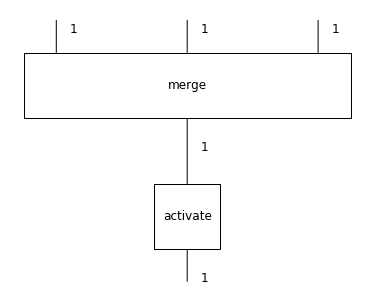

In [2]:
neuron(3).draw(draw_types=False)

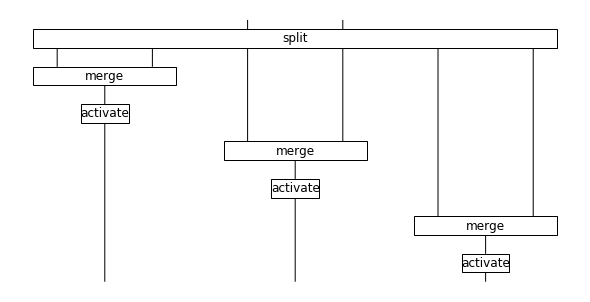

In [13]:
layer(2, 3).draw(draw_types=False, aspect='auto', figsize=(8, 4))

In [4]:
# The semantics is given by discopy Functions

from discopy import *
from discopy.function import Vec, Function, Id, discofunc

def mult(weight): 
    return Function('mult({})'.format(str(weight)), 1, 1, lambda x: weight * x)
    
def mults(dom, weights):
    result = Id(0)
    for i in range(dom):
        result = result @ mult(weights[i])
    result._name = 'mults({})'.format(str(weights))
    return result

def bias(weight):
    return Function('bias({})'.format(str(weight)), Vec(0), Vec(1), lambda x: np.array([weight]))

def add(cod, copies):
    @discofunc(cod * copies, cod, name='add({}, {})'.format(cod, copies))
    def merge(x):
        return np.array([np.sum([x[i + cod * j] for j in range(copies)]) for i in range(cod)])
    return merge

sigmoid = Function('sigmoid', 1, 1, lambda x: 1/(1 + np.exp(-x)))

In [5]:
def Neuron(dom, weights, beta=0): 
    # weights is a 1d array of length dom, beta is a scalar bias
    return mults(dom, weights) @ bias(beta) >> add(1, dom + 1) >> sigmoid

We can jit and take the gradient of neurons using Jax.

In [6]:
import jax.numpy as np
from jax import jit, grad

print(jit(Neuron(4, [0, 2.1, 0.3, 0.1]))(np.array([0., 0.3, 1.2, 3.2])))
print(grad(lambda x: Neuron(4, [0., 2.1, 0.3, 0.1])(x)[0])(np.array([0., 0.3, 1.2, 3.2])))

[0.7875132]
[0.         0.35140604 0.05020086 0.01673362]


In [7]:
from discopy.function import Copy

def Layer(dom, cod, weights, biases): # weights is an array of shape: (cod, dom) (note cod = number of neurons)
    neurons = Id(0)                   # biases is a 1d array of shape (cod, )
    for i in range(cod):
        neurons = neurons @ Neuron(dom, weights[i], biases[i])
    return Copy(dom, cod) >> neurons

In [8]:
disconnected_layer = lambda x: Layer(3, 1, [[0., 0., 0.]], [0., 0.])(x)[0]
assert np.all(grad(disconnected_layer)(np.array([2., 3.4, 1.])) == np.array([0., 0., 0.]))

In [9]:
def neural_net(layers, weights, biases): 
    # each layer has layer[i] neurons and is fully connected to adjacent layers 
    # weights is a list of arrays of shape (layers[i+1], layers[i]) of length len(layers) - 1
    # biases is a list of 1d arrays of shape (layers[i], ) of length len(layers) - 1
    result = Id(layers[0])
    for i in range(len(layers) - 1):
        result = result >> Layer(layers[i], layers[i + 1], weights[i], biases[i])
    return result

In [10]:
from random import uniform

layers = [2, 3, 1]
weights = [[[uniform(-10, 10) for k in range(layers[i])] for j in range(layers[i+1])] for i in range(len(layers) - 1)]
biases = [[uniform(-5, 5) for j in range(layers[i+1])] for i in range(len(layers) - 1)]

nnet = lambda x: neural_net(layers, weights, biases)(x)[0]
jit(nnet)
print(nnet([2.23, 4.2]))
print(grad(nnet)([2., 4.]))

0.82361406
[DeviceArray(-0.10283893, dtype=float32), DeviceArray(0.04633135, dtype=float32)]
